In [1]:
from DLtools.Data_preprocess import load_data, series_to_supervised

import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten, LSTM, RepeatVector,TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping


In [2]:
r='data/instant_data/rain_small.csv'
w='data/instant_data/water_small.csv'
rw = load_data(r,w)
df =rw.df.resample('d').mean()

DataFrame shape: (465169, 35)


In [3]:
X_in = df['2013-01-01':'2015-01-01'].interpolate(limit=30)
X_in = X_in.astype('float32')
X_in = df.fillna(0)

#SCALE
scale = MinMaxScaler()
X_in = scale.fit_transform(X_in)

https://machinelearningmastery.com/how-to-develop-lstm-models-for-multi-step-time-series-forecasting-of-household-power-consumption/

In [4]:
def train_test(data,n_out):    
    ratio = int(len(data)*.7)
    d_start = int(ratio-ratio%n_out)
    d_end = int(len(data)-len(data)%n_out)
    #train,test = X_in.iloc[:700,:].values,X_in.iloc[700:777,:].values
    train,test = data[:d_start,:],data[d_start:d_end,:]

    train = np.array(np.split(train, len(train)/n_out))
    test = np.array(np.split(test, len(test)/n_out))
    return train,test


In [5]:
def to_supervised(train, n_input, n_out=7):
    # flatten data
    try :
        data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
    except:
        data = train.values
    X, y = list(), list()
    in_start = 0
    # step over the entire history one time step at a time
    for _ in range(len(data)):
        # define the end of the input sequence
        in_end = in_start + n_input
        out_end = in_end + n_out   
        # ensure we have enough data for this instance
        if out_end <= len(data):
            x_input = data[in_start:in_end, 0]
            x_input = x_input.reshape((len(x_input), 1))
            X.append(data[in_start:in_end, :])
            y.append(data[in_end:out_end, 0])
        # move along one time step
        in_start += 1
    return np.array(X), np.array(y)

# make a forecast
def forecast(model, history, n_input):
	# flatten data
	data = np.array(history)
	data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
	# retrieve last observations for input data
	input_x = data[-n_input:, :]
	# reshape into [1, n_input, 1]
	input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1]))
	# forecast the next week
	yhat = model.predict(input_x, verbose=0)
	# we only want the vector forecast
	yhat = yhat[0]
	return yhat


In [6]:

def build_model_seq2seq(train, n_input):
    # define parameters
    train_x, train_y = to_supervised(train, n_input)
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    callback_early_stopping = EarlyStopping(monitor='val_loss',patience=5, verbose=2)
    callbacks = [callback_early_stopping]

    # define model
    verbose, epochs, batch_size = 0, 50, 16
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    
    # reshape output into [samples, timesteps, features]
    train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
    # define model
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
    model.add(RepeatVector(n_outputs))                                  # Decoder 
    model.add(LSTM(200, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(100, activation='relu')))
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss='mse', optimizer='adam')
    model.summary()
    # fit network
    history = model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose,
    validation_data=VALIDATION,callbacks=callbacks)
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.show()
    return model

# evaluate a single model
def evaluate_model(train, test, n_input):
	# fit model
	model = build_model_seq2seq(train, n_input)
	# history is a list of weekly data
	history = [x for x in train]
	# walk-forward validation over each week
	predictions = list()
	for i in range(len(test)):
		# predict the week
		yhat_sequence = forecast(model, history, n_input)
		# store the predictions
		predictions.append(yhat_sequence)
		# get real observation and add to history for predicting the next week
		history.append(test[i, :])
	# evaluate predictions days for each week
	predictions = np.array(predictions)
	score, scores = evaluate_forecasts(test[:, :, 0], predictions)
	return score, scores

def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))


In [7]:
def forecast(model, history, n_input):
	# flatten data
	data = np.array(history)
	data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
	# retrieve last observations for input data
	input_x = data[-n_input:, 0]
	# reshape into [1, n_input, 1]
	input_x = input_x.reshape((1, len(input_x), 1))
	# forecast the next week
	yhat = model.predict(input_x, verbose=0)
	# we only want the vector forecast
	yhat = yhat[0]
	return yhat

In [8]:
def to_supervised(train, n_input, n_out=7):
    # flatten data
    try :
        data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
    except:
        data = train.values
    X, y = list(), list()
    in_start = 0
    # step over the entire history one time step at a time
    for _ in range(len(data)):
        # define the end of the input sequence
        in_end = in_start + n_input
        out_end = in_end + n_out   
        # ensure we have enough data for this instance
        if out_end <= len(data):
            x_input = data[in_start:in_end, 0]
            x_input = x_input.reshape((len(x_input), 1))
            X.append(x_input)
            y.append(data[in_end:out_end, 0])
        # move along one time step
        in_start += 1
    return np.array(X), np.array(y)
    
def evaluate_forecasts(actual, predicted):
    scores = list()
    # calculate an RMSE score for each day
    for i in range(actual.shape[1]):
        # calculate mse
        mse = mean_squared_error(actual[:, i], predicted[:, i])
        # store
        scores.append(mse)
    # calculate overall RMSE
    s = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    #score = math.sqrt(s / (actual.shape[0] * actual.shape[1]))
    score = (s / (actual.shape[0] * actual.shape[1]))
    return score, scores

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 200)               161600    
_________________________________________________________________
repeat_vector (RepeatVector) (None, 7, 200)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 7, 200)            320800    
_________________________________________________________________
time_distributed (TimeDistri (None, 7, 100)            20100     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 7, 1)              101       
Total params: 502,601
Trainable params: 502,601
Non-trainable params: 0
_________________________________________________________________
Epoch 00013: early stopping


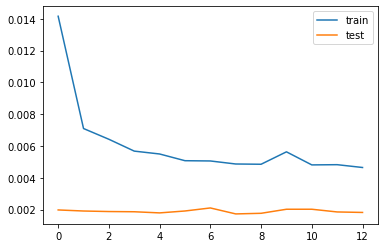

lstm_seq2seq: [0.003] 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0


In [9]:
n_input = 14
n_out = 7

train, test = train_test(X_in,n_out=n_out)
val_x, val_y = to_supervised(test, n_input)
VALIDATION = (val_x,val_y)

score, scores = evaluate_model(train, test, n_input)
# summarize scores
summarize_scores('lstm_seq2seq', score, scores)